<a href="https://colab.research.google.com/github/Abhy611/Variational-Autoencoders/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))  # by default, random_normal has mean=0 and std=1.0
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(y_train.shape)

dig_class = 1

indexes = []
for i, j in enumerate(y_train):
    if j == dig_class:
        indexes.append(i)


x_train_t = x_train[indexes]

indexes = []
for i, j in enumerate(y_test):
    if j == dig_class:
        indexes.append(i)


x_test_t = x_test[indexes]


x_train = x_train_t
x_test = x_test_t
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(60000,)
(6742, 28, 28)
(1135, 28, 28)


In [ ]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# sampling
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  401920    ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense[0][0]']               
                                                                                            

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807700 (3.08 MB)
Trainable params: 807700 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [ ]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  403972    ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  403728    ['encoder[0][2]']             
                                                                                                

In [ ]:
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/50
53/53 [==============================] - 6s 58ms/step - loss: 211.8199 - val_loss: 100.3486
Epoch 2/50
53/53 [==============================] - 2s 47ms/step - loss: 84.4193 - val_loss: 72.7791
Epoch 3/50
53/53 [==============================] - 3s 48ms/step - loss: 70.5238 - val_loss: 66.5543
Epoch 4/50
53/53 [==============================] - 3s 53ms/step - loss: 66.3462 - val_loss: 63.9779
Epoch 5/50
53/53 [==============================] - 4s 67ms/step - loss: 64.4712 - val_loss: 62.7632
Epoch 6/50
53/53 [==============================] - 3s 51ms/step - loss: 63.3381 - val_loss: 61.9752
Epoch 7/50
53/53 [==============================] - 3s 53ms/step - loss: 62.5846 - val_loss: 61.4457
Epoch 8/50
53/53 [==============================] - 3s 48ms/step - loss: 62.0313 - val_loss: 60.7105
Epoch 9/50
53/53 [==============================] - 3s 64ms/step - loss: 61.4061 - val_loss: 59.9614
Epoch 10/50
53/53 [==============================] - 3s 60ms/step - loss: 60.3651 - val_l

In [ ]:
vae.save_weights('vae_mnist.h5')

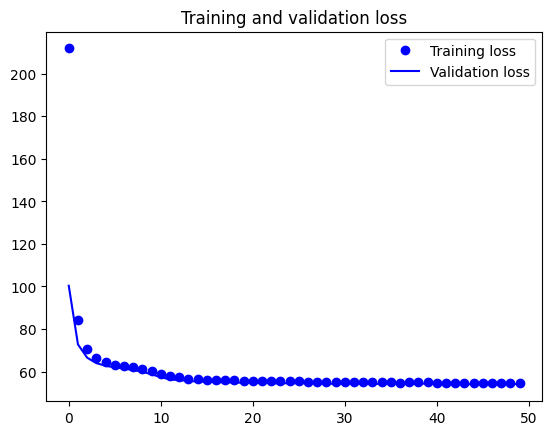

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

9/9 [==============================] - 0s 4ms/step


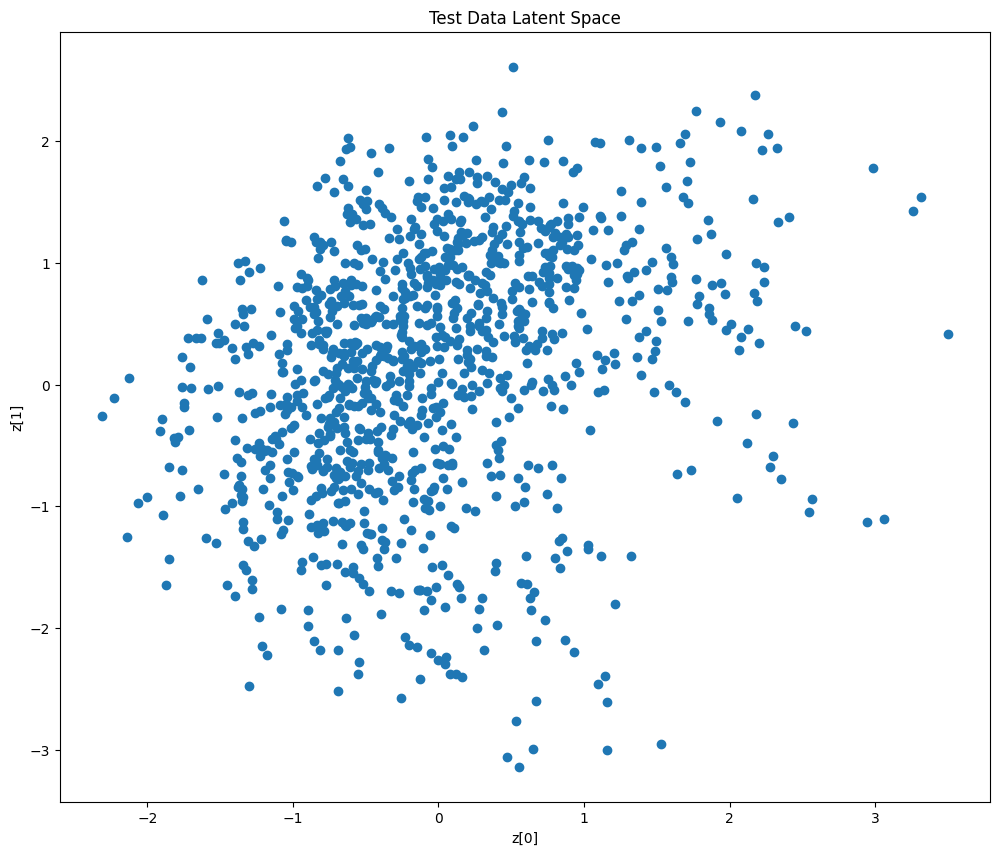

In [ ]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Test Data Latent Space')
plt.show()

53/53 [==============================] - 0s 4ms/step


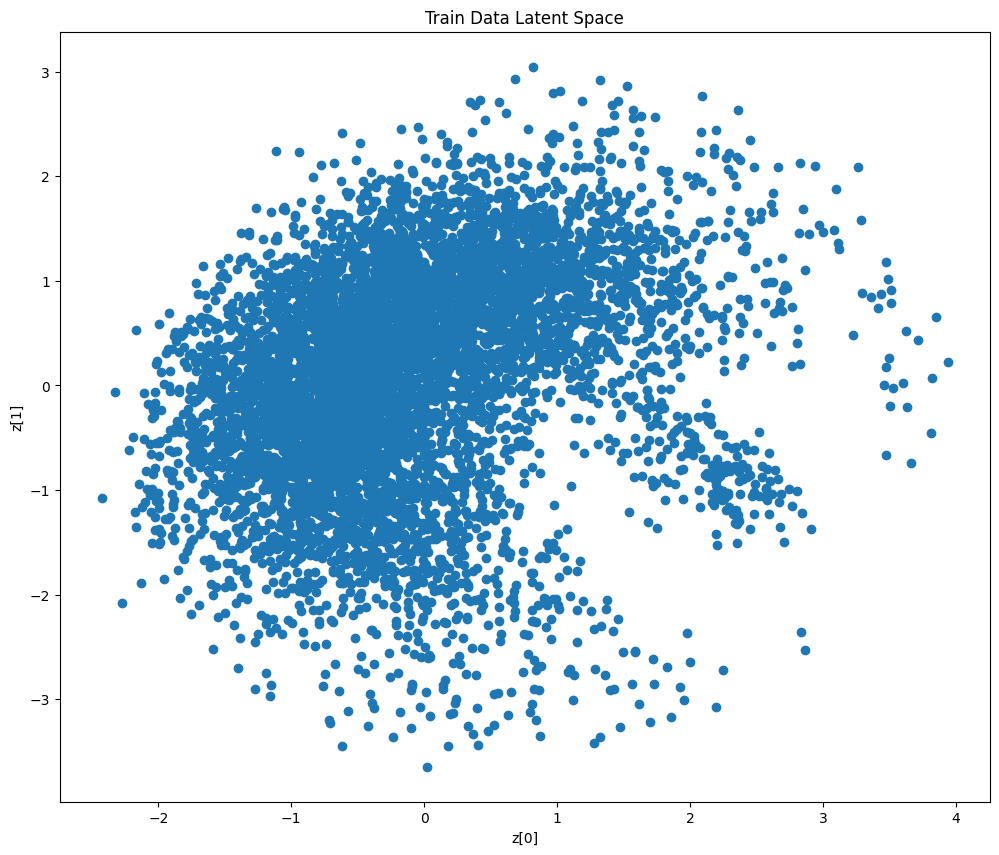

In [ ]:
z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Train Data Latent Space')
plt.show()

1/1 [==============================] - 0s 19ms/step


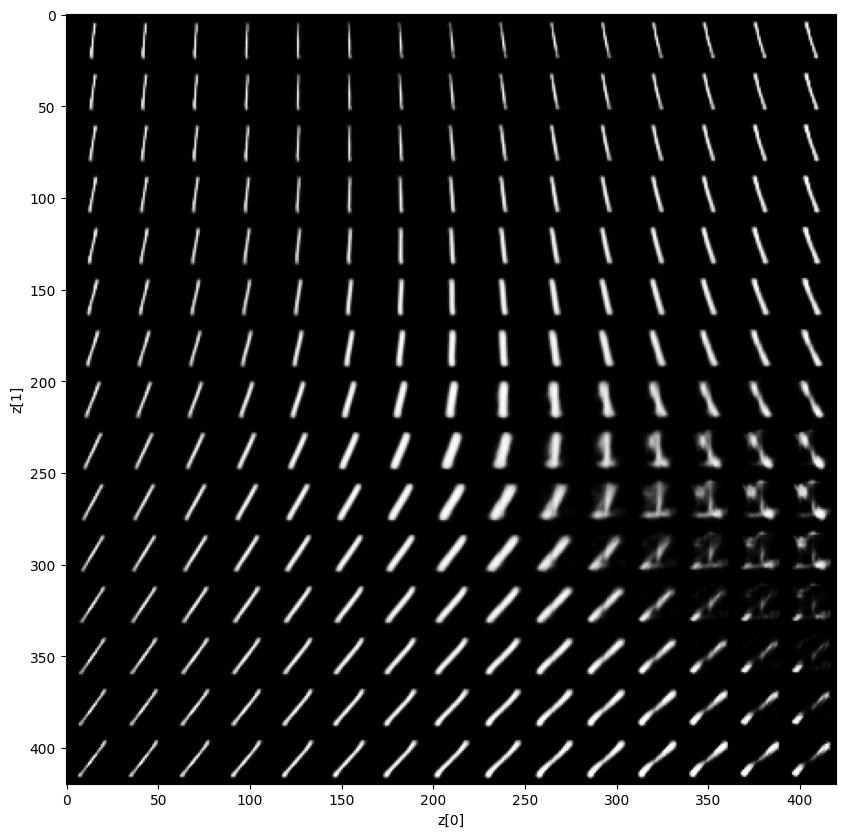

In [ ]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
           z_sample = np.array([[xi, yi]])
           x_decoded = decoder.predict(z_sample)
           digit = x_decoded[0].reshape(digit_size, digit_size)
           figure[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
#plt.xticks(pixel_range, sample_range_x)
#plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='gray')
plt.show()

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

79/79 [==============================] - 0s 4ms/step


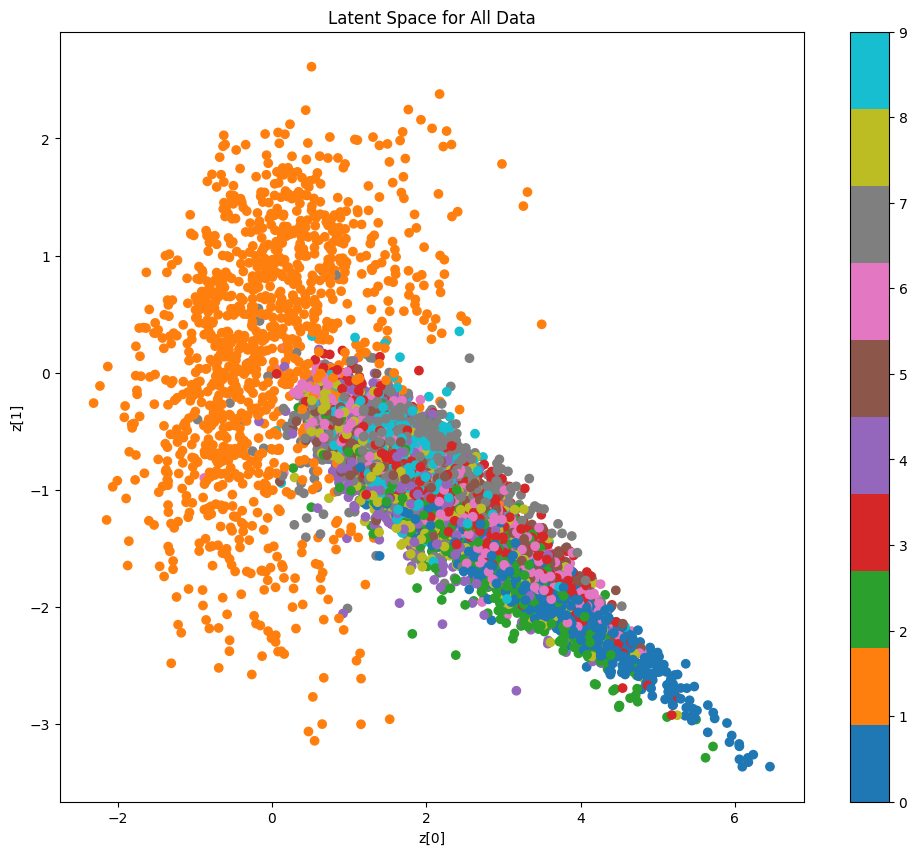

In [ ]:
z_mean,z_log_var, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.set_cmap('tab10')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Latent Space for All Data')
plt.show()

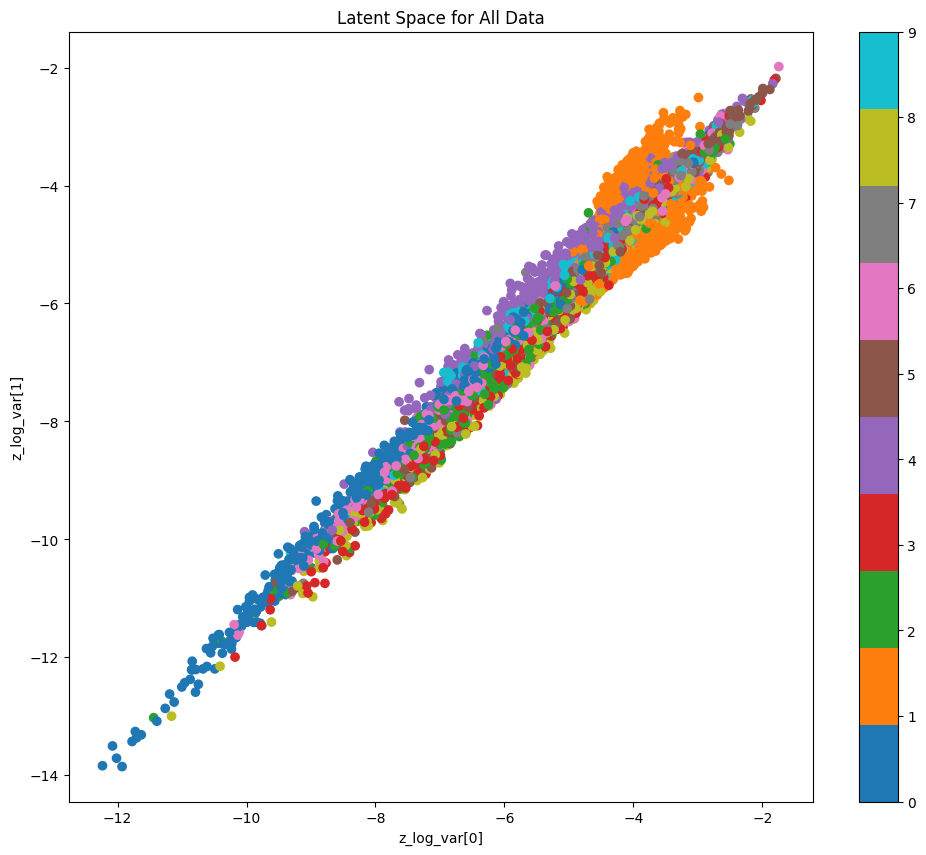

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(z_log_var[:, 0], z_log_var[:, 1], c=y_test)
plt.colorbar()
plt.set_cmap('tab10')
plt.xlabel("z_log_var[0]")
plt.ylabel("z_log_var[1]")
plt.title('Latent Space for All Data')
plt.show()

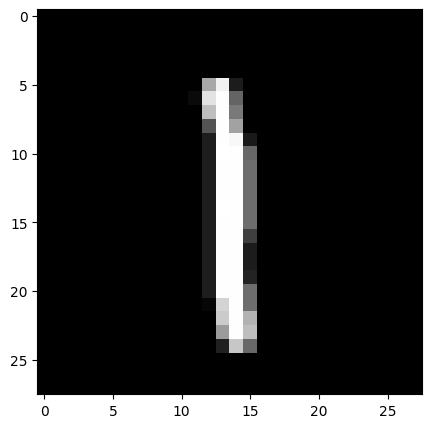

313/313 [==============================] - 1s 2ms/step


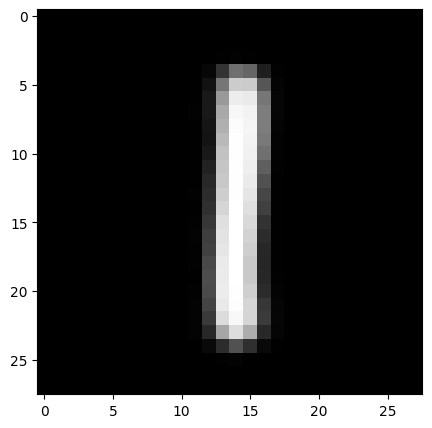

In [ ]:
i = 14

digit_size = 28


digit = x_train[i].reshape(digit_size, digit_size)

figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='gray')
plt.show()



z_sample = np.array(z_mean)
x_decoded = decoder.predict(z_sample)
digit = x_decoded[i].reshape(digit_size, digit_size)


figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='gray')
plt.show()

313/313 [==============================] - 1s 2ms/step


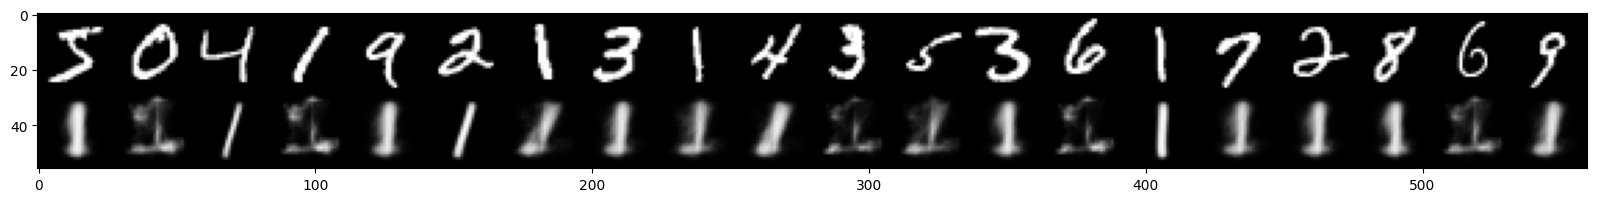

In [ ]:
n = 20
digit_size = 28
figure = np.zeros((digit_size * 2, digit_size * n))
grid_x = np.linspace(0, n, n)


for j, xi in enumerate(grid_x):
      z_sample = np.array(z_mean)
      x_decoded = decoder.predict(z_sample)
      digit = x_train[j].reshape(digit_size, digit_size)
      figure[0 * digit_size: (0 + 1) * digit_size,
             j * digit_size: (j + 1) * digit_size] = digit
      digit = x_decoded[j].reshape(digit_size, digit_size)
      figure[1 * digit_size: (1 + 1) * digit_size,
             j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(n, n))

plt.imshow(figure, cmap='gray')
plt.show()